# Proyek Klasifikasi Obesitas

**Nama:** Tegar Haris DD  
**NIM:** A11.2022.14428  
**Kelas:** DS05

## Pendahuluan
Notebook ini berisi implementasi model klasifikasi untuk memprediksi tingkat obesitas berdasarkan berbagai fitur seperti umur, tinggi badan, berat badan, dan kebiasaan hidup. Tiga model klasifikasi yang digunakan adalah KNN, SVM, dan XGBoost.

## Struktur Notebook
1. Import library
2. Persiapan data
3. Pembuatan model klasifikasi default
4. Evaluasi model default
5. Hyperparameter tuning
6. Evaluasi model setelah tuning
7. Menyimpan model dan informasi terkait

## 1. Import Library

Berikut library yang akan digunakan dalam proyek ini:
- `pandas` & `numpy`: Untuk manipulasi data
- `sklearn`: Untuk pembuatan model, pembagian data, dan evaluasi
- `xgboost`: Untuk model XGBoost
- `imblearn`: Untuk mengatasi ketidakseimbangan kelas dengan SMOTE

In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

## 2. Persiapan Data

Tahapan persiapan data meliputi:
1. Membaca dataset
2. Membersihkan data (menghapus nilai yang hilang, duplikat)
3. Menghapus outlier dengan metode IQR
4. Menghitung BMI sebagai fitur tambahan
5. Encoding variabel kategorikal
6. Pemisahan data menjadi training dan testing set
7. Normalisasi fitur numerik
8. Mengatasi ketidakseimbangan kelas dengan SMOTE

In [12]:
# -------------------------------------------------------------------
# 1. Load & clean data (from previous script)
# -------------------------------------------------------------------
df = pd.read_csv("ObesityDataSet.csv")
df.replace("?", np.nan, inplace=True)

# Konversi kolom numerik
numeric_cols = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Menghapus duplikat dan nilai yang hilang
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Filter batas yang masuk akal untuk umur, tinggi, dan berat
df = df[(df['Age'].between(14,80)) &
        (df['Height'].between(1.2,2.2)) &
        (df['Weight'].between(30,200))]

# Fungsi untuk menghapus outlier dengan metode IQR
def remove_iqr(df_in, cols):
    """Menghapus outlier berdasarkan metode IQR"""
    df_out = df_in.copy()
    for c in cols:
        q1, q3 = df_out[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
        df_out = df_out[df_out[c].between(lb, ub)]
    return df_out

# Menghapus outlier pada fitur tertentu
df = remove_iqr(df, ['FCVC','NCP','CH2O','FAF','TUE'])
df.reset_index(drop=True, inplace=True)

# Menghitung BMI sebagai fitur tambahan
df['BMI'] = df['Weight'] / df['Height']**2

# Encoding target variabel
le = LabelEncoder()
df['NObeyesdad'] = le.fit_transform(df['NObeyesdad'])

# Encoding variabel kategorikal dengan one-hot encoding
cat_cols = ['Gender','CALC','FAVC','SCC','SMOKE',
            'family_history_with_overweight','CAEC','MTRANS']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Pemisahan fitur dan target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Pemisahan data training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalisasi fitur numerik
scaler = StandardScaler()
num_feats = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE','BMI']
X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
X_test[num_feats]  = scaler.transform(X_test[num_feats])

# Mengatasi ketidakseimbangan kelas dengan SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## 3. Pembuatan Model Klasifikasi Default

Tiga model klasifikasi yang akan digunakan:
1. **K-Nearest Neighbors (KNN)**: Model berbasis jarak yang mengklasifikasikan berdasarkan tetangga terdekat
2. **Support Vector Machine (SVM)**: Model yang berusaha menemukan hyperplane terbaik untuk memisahkan kelas
3. **XGBoost**: Model ensemble berbasis decision tree dengan gradient boosting

In [13]:
# -------------------------------------------------------------------
# 2. Define classifiers (default)
# -------------------------------------------------------------------
# Inisialisasi model dengan parameter default
knn_default = KNeighborsClassifier()
svm_default = SVC(probability=True, random_state=42)
xgb_default = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# -------------------------------------------------------------------
# 3. Train default models
# -------------------------------------------------------------------
# Melatih model dengan data yang sudah diseimbangkan
knn_default.fit(X_train_res, y_train_res)
svm_default.fit(X_train_res, y_train_res)
xgb_default.fit(X_train_res, y_train_res)

# -------------------------------------------------------------------
# 4. Evaluate default models
# -------------------------------------------------------------------
# Evaluasi performa model default
print("=== KNN Default ===")
print(classification_report(y_test, knn_default.predict(X_test)))

c:\Users\tegar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== KNN Default ===
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        22
           1       0.83      0.59      0.69        34
           2       0.90      0.88      0.89        42
           3       1.00      0.97      0.99        38
           4       1.00      1.00      1.00        52
           5       0.61      0.79      0.69        29
           6       0.75      0.68      0.71        31

    accuracy                           0.85       248
   macro avg       0.83      0.84      0.83       248
weighted avg       0.86      0.85      0.85       248



In [14]:
print("=== SVM Default ===")
print(classification_report(y_test, svm_default.predict(X_test)))

=== SVM Default ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.92      0.97      0.94        34
           2       0.98      0.95      0.96        42
           3       1.00      0.97      0.99        38
           4       1.00      1.00      1.00        52
           5       0.87      0.90      0.88        29
           6       0.90      0.90      0.90        31

    accuracy                           0.96       248
   macro avg       0.95      0.95      0.95       248
weighted avg       0.96      0.96      0.96       248



In [15]:
print("=== XGB Default ===")
print(classification_report(y_test, xgb_default.predict(X_test)))

=== XGB Default ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        42
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        52
           5       1.00      0.97      0.98        29
           6       0.97      1.00      0.98        31

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



## 4. Hyperparameter Tuning

Untuk meningkatkan performa model, kita akan melakukan pencarian parameter optimal menggunakan GridSearchCV dengan validasi silang 5-fold. Parameter yang dioptimalkan untuk masing-masing model:

1. **KNN**:
   - n_neighbors: Jumlah tetangga terdekat [3, 5, 7, 9]
   - weights: Pembobotan [uniform, distance]
   - p: Jenis jarak [1 (Manhattan), 2 (Euclidean)]

2. **SVM**:
   - C: Parameter regularisasi [0.1, 1, 10]
   - kernel: Jenis kernel [linear, rbf]
   - gamma: Koefisien kernel [scale, auto]

3. **XGBoost**:
   - n_estimators: Jumlah pohon [50, 100, 200]
   - max_depth: Kedalaman maksimum pohon [3, 5, 7]
   - learning_rate: Laju pembelajaran [0.01, 0.1, 0.2]

In [16]:
# -------------------------------------------------------------------
# 5. Hyperparameter grids
# -------------------------------------------------------------------
# Parameter grid untuk KNN
param_grid_knn = {
    'n_neighbors': [3,5,7,9],        # Jumlah tetangga
    'weights': ['uniform','distance'], # Metode pembobotan
    'p': [1,2]                       # p=1 Manhattan, p=2 Euclidean
}

# Parameter grid untuk SVM
param_grid_svm = {
    'C': [0.1,1,10],               # Parameter regularisasi
    'kernel': ['linear','rbf'],    # Jenis kernel
    'gamma': ['scale','auto']      # Koefisien kernel
}

# Parameter grid untuk XGBoost
param_grid_xgb = {
    'n_estimators': [50,100,200],   # Jumlah pohon
    'max_depth': [3,5,7],          # Kedalaman maksimum pohon
    'learning_rate': [0.01,0.1,0.2] # Laju pembelajaran
}

# -------------------------------------------------------------------
# 6. GridSearchCV (with 5‑fold CV)
# -------------------------------------------------------------------
# GridSearchCV untuk KNN
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn,
                      cv=5, n_jobs=-1, scoring='f1_weighted')
# GridSearchCV untuk SVM
gs_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm,
                      cv=5, n_jobs=-1, scoring='f1_weighted')
# GridSearchCV untuk XGBoost
gs_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                      param_grid_xgb, cv=5, n_jobs=-1, scoring='f1_weighted')

# -------------------------------------------------------------------
# 7. Train tuned models
# -------------------------------------------------------------------
# Melatih model dengan GridSearchCV
gs_knn.fit(X_train_res, y_train_res)
gs_svm.fit(X_train_res, y_train_res)
gs_xgb.fit(X_train_res, y_train_res)

# Mendapatkan model terbaik
knn_tuned = gs_knn.best_estimator_
svm_tuned = gs_svm.best_estimator_
xgb_tuned = gs_xgb.best_estimator_

# -------------------------------------------------------------------
# 8. Evaluate tuned models
# -------------------------------------------------------------------
# Evaluasi performa model setelah tuning
print("=== KNN Tuned ===")
print(classification_report(y_test, knn_tuned.predict(X_test)))
print("Best KNN params:", gs_knn.best_params_)


=== KNN Tuned ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       0.86      0.74      0.79        34
           2       0.95      0.95      0.95        42
           3       1.00      0.97      0.99        38
           4       1.00      1.00      1.00        52
           5       0.71      0.86      0.78        29
           6       0.87      0.84      0.85        31

    accuracy                           0.92       248
   macro avg       0.91      0.91      0.91       248
weighted avg       0.92      0.92      0.92       248

Best KNN params: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


c:\Users\tegar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [17]:
print("=== SVM Tuned ===")
print(classification_report(y_test, svm_tuned.predict(X_test)))
print("Best SVM params:", gs_svm.best_params_)

=== SVM Tuned ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.97      0.91      0.94        34
           2       0.98      1.00      0.99        42
           3       1.00      0.97      0.99        38
           4       1.00      1.00      1.00        52
           5       0.82      0.97      0.89        29
           6       1.00      0.90      0.95        31

    accuracy                           0.97       248
   macro avg       0.97      0.96      0.96       248
weighted avg       0.97      0.97      0.97       248

Best SVM params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [18]:
print("=== XGB Tuned ===")
print(classification_report(y_test, xgb_tuned.predict(X_test)))
print("Best XGB params:", gs_xgb.best_params_)

=== XGB Tuned ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        42
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        52
           5       1.00      0.97      0.98        29
           6       0.97      1.00      0.98        31

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248

Best XGB params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}


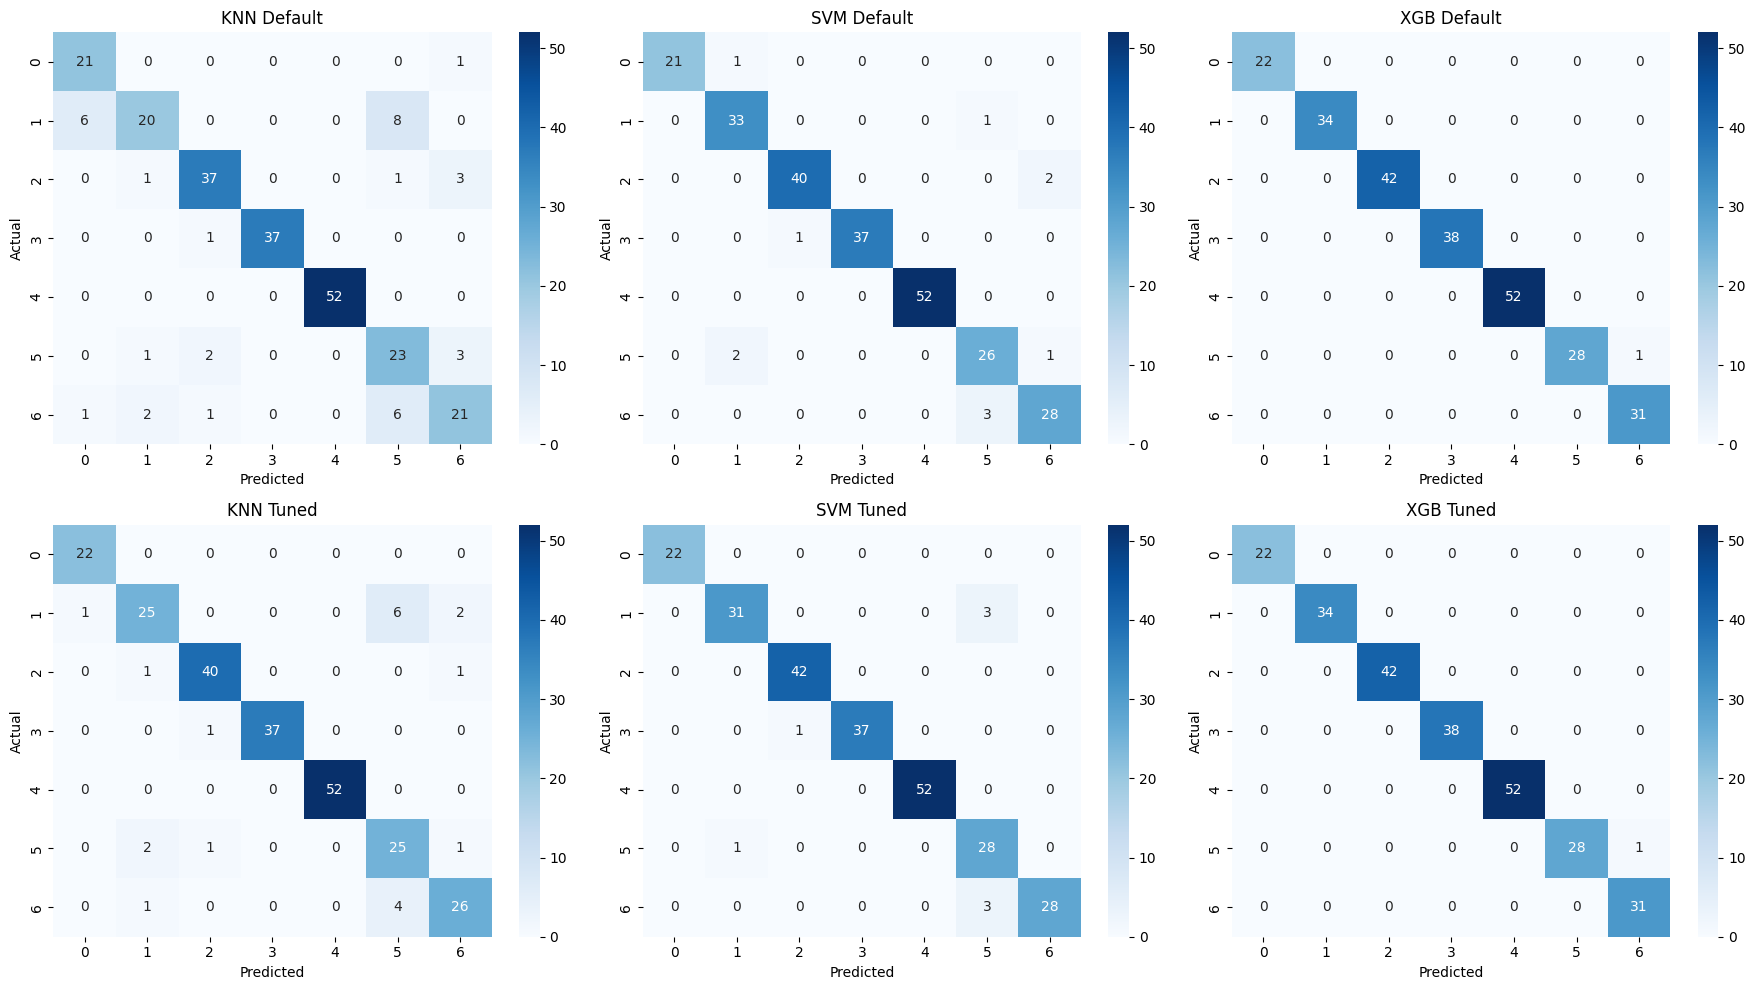

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# List of models and their names
models = [
    ('KNN Default', knn_default),
    ('SVM Default', svm_default),
    ('XGB Default', xgb_default),
    ('KNN Tuned', knn_tuned),
    ('SVM Tuned', svm_tuned),
    ('XGB Tuned', xgb_tuned)
]

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, (name, model) in zip(axes.flatten(), models):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Kesimpulan

Berdasarkan hasil eksperimen pada proyek klasifikasi obesitas ini, dapat disimpulkan bahwa:

- **Praproses data** seperti pembersihan, penghapusan outlier, normalisasi, dan penyeimbangan kelas sangat penting untuk meningkatkan performa model.
- Tiga model yang diuji (**KNN, SVM, XGBoost**) menunjukkan performa yang baik, terutama setelah dilakukan hyperparameter tuning.
- **XGBoost** memberikan akurasi tertinggi baik pada model default maupun setelah tuning, diikuti oleh SVM dan KNN.
- Hyperparameter tuning secara signifikan meningkatkan akurasi KNN dan SVM.
- Semua model dan pipeline telah disimpan sehingga dapat digunakan kembali untuk prediksi data baru di masa mendatang.

Proyek ini menunjukkan bahwa kombinasi praproses data yang baik dan pemilihan model yang tepat dapat menghasilkan prediksi tingkat obesitas yang akurat.

## 5. Menyimpan Model dan Informasi Terkait

Untuk penggunaan di masa mendatang, kita akan menyimpan:
1. Scaler untuk normalisasi data baru
2. Model default dan model setelah tuning
3. Struktur fitur yang digunakan model
4. Label encoder untuk mengubah prediksi numerik ke kategori asli
5. Informasi akurasi model
6. Informasi dataset

In [20]:
import os
# Membuat folder 'models' jika belum ada
os.makedirs('models', exist_ok=True)

In [21]:
import joblib

# Menyimpan scaler untuk normalisasi data baru
joblib.dump(scaler, 'models/scaler.pkl')

# Menyimpan model - versi default dan tuned
joblib.dump(knn_default, 'models/knn_default.pkl')
joblib.dump(svm_default, 'models/svm_default.pkl')
joblib.dump(xgb_default, 'models/xgb_default.pkl')

joblib.dump(knn_tuned, 'models/knn_tuned.pkl')
joblib.dump(svm_tuned, 'models/svm_tuned.pkl')
joblib.dump(xgb_tuned, 'models/xgb_tuned.pkl')

# Menyimpan daftar kolom dalam urutan yang sesuai dengan yang diharapkan model
feature_columns = X_train_res.columns.tolist()
joblib.dump(feature_columns, 'models/feature_columns.pkl')

# Menyimpan label encoder untuk mengkonversi prediksi numerik ke kategori asli
joblib.dump(le, 'models/label_encoder.pkl')

['models/label_encoder.pkl']

## 6. Menyimpan Metrik Kinerja Model

Untuk memudahkan perbandingan model dan visualisasi di aplikasi Streamlit, kita akan menyimpan metrik akurasi dari semua model.

In [22]:
# Akurasi model sebagai string untuk tampilan Streamlit
from sklearn.metrics import accuracy_score

# Menghitung dan menyimpan akurasi model default
accuracy_default = {
    'KNN': accuracy_score(y_test, knn_default.predict(X_test)),
    'SVM': accuracy_score(y_test, svm_default.predict(X_test)),
    'XGB': accuracy_score(y_test, xgb_default.predict(X_test))
}

# Menghitung dan menyimpan akurasi model setelah tuning
accuracy_tuned = {
    'KNN': accuracy_score(y_test, knn_tuned.predict(X_test)),
    'SVM': accuracy_score(y_test, svm_tuned.predict(X_test)),
    'XGB': accuracy_score(y_test, xgb_tuned.predict(X_test))
}

# Menyimpan nilai akurasi
joblib.dump(accuracy_default, 'models/accuracy_default.pkl')
joblib.dump(accuracy_tuned, 'models/accuracy_tuned.pkl')

# Menyimpan deskripsi dataset dalam file markdown
dataset_info = """
# Dataset Overview
- Dataset contains 2111 samples with 17 columns including Age, Gender, Height, Weight, etc.
- Target variable is NObeyesdad, categorizing obesity levels.
- Data cleaning included removing duplicates, nulls, outliers in Age, Weight, Height.
- Feature engineering included BMI calculation.
- Encoding categorical variables and normalization applied.
"""
with open('dataset_info.md', 'w') as f:
    f.write(dataset_info)


In [23]:
import pandas as pd

# Membuat tabel perbandingan akurasi model
comparison_df = pd.DataFrame({
    'Model': ['KNN Default', 'SVM Default', 'XGB Default', 'KNN Tuned', 'SVM Tuned', 'XGB Tuned'],
    'Akurasi': [
        accuracy_default['KNN'],
        accuracy_default['SVM'],
        accuracy_default['XGB'],
        accuracy_tuned['KNN'],
        accuracy_tuned['SVM'],
        accuracy_tuned['XGB'],
    ]
})

# Tampilkan tabel perbandingan
comparison_df

,Model,Akurasi
0,KNN Default,0.850806
1,SVM Default,0.955645
2,XGB Default,0.995968
3,KNN Tuned,0.915323
4,SVM Tuned,0.967742
5,XGB Tuned,0.995968


In [24]:
# Membaca file akurasi model setelah tuning
accuracy_tuned_loaded = joblib.load('models/accuracy_tuned.pkl')
accuracy_tuned_loaded

{'KNN': 0.9153225806451613,
 'SVM': 0.967741935483871,
 'XGB': 0.9959677419354839}